In [2]:
from json import load
with open("useful_6x6_1mb.json") as f:
  full_log = load(f)

In [3]:
hosts = list(full_log.keys())
intervals = list(full_log[hosts[0]].keys())
lengths = list(full_log[hosts[0]][intervals[0]].keys())
sides = list(full_log[hosts[0]][intervals[0]][lengths[0]].keys())
metrics = list(full_log[hosts[0]][intervals[0]][lengths[0]][sides[0]].keys())

In [4]:
differences = dict()
for host in hosts:
  differences[host] = dict()
  for interval in intervals:
    differences[host][interval] = dict()
    for length in lengths:
      differences[host][interval][length] = dict()
      for metric in metrics[:2]:
        differences[host][interval][length][metric] = full_log[host][interval][length]["client"][metric] - full_log[host][interval][length]["server"][metric]
        differences[host][interval][length][metric + "_loss_ratio"] = differences[host][interval][length][metric] / full_log[host][interval][length]["client"][metric]
      differences[host][interval][length]["time"] = max(full_log[host][interval][length]["client"]["time"], full_log[host][interval][length]["server"]["time"])
      differences[host][interval][length]["data_rate"] = full_log[host][interval][length]["server"]["data"] / differences[host][interval][length]["time"] / 1024 * 8

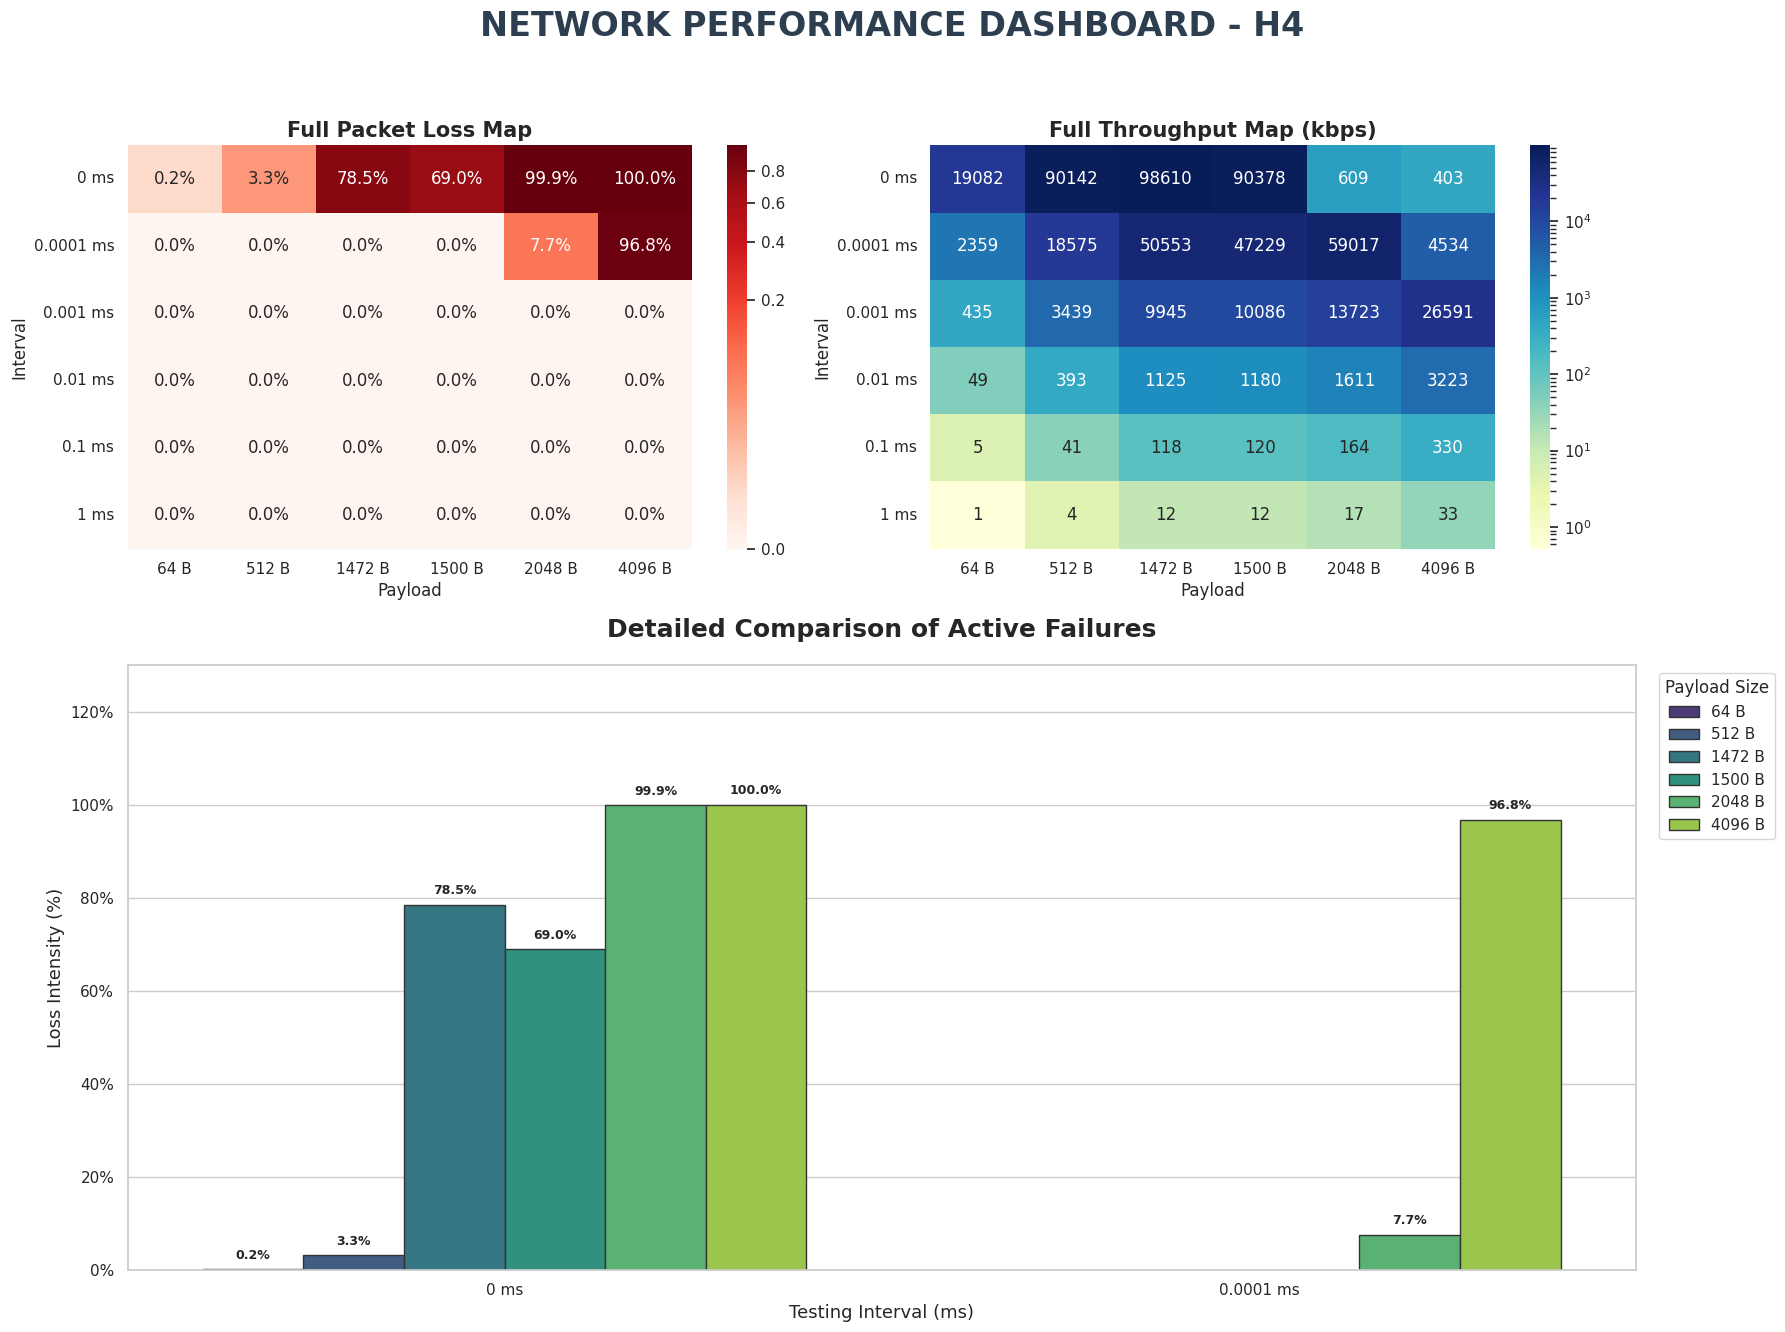

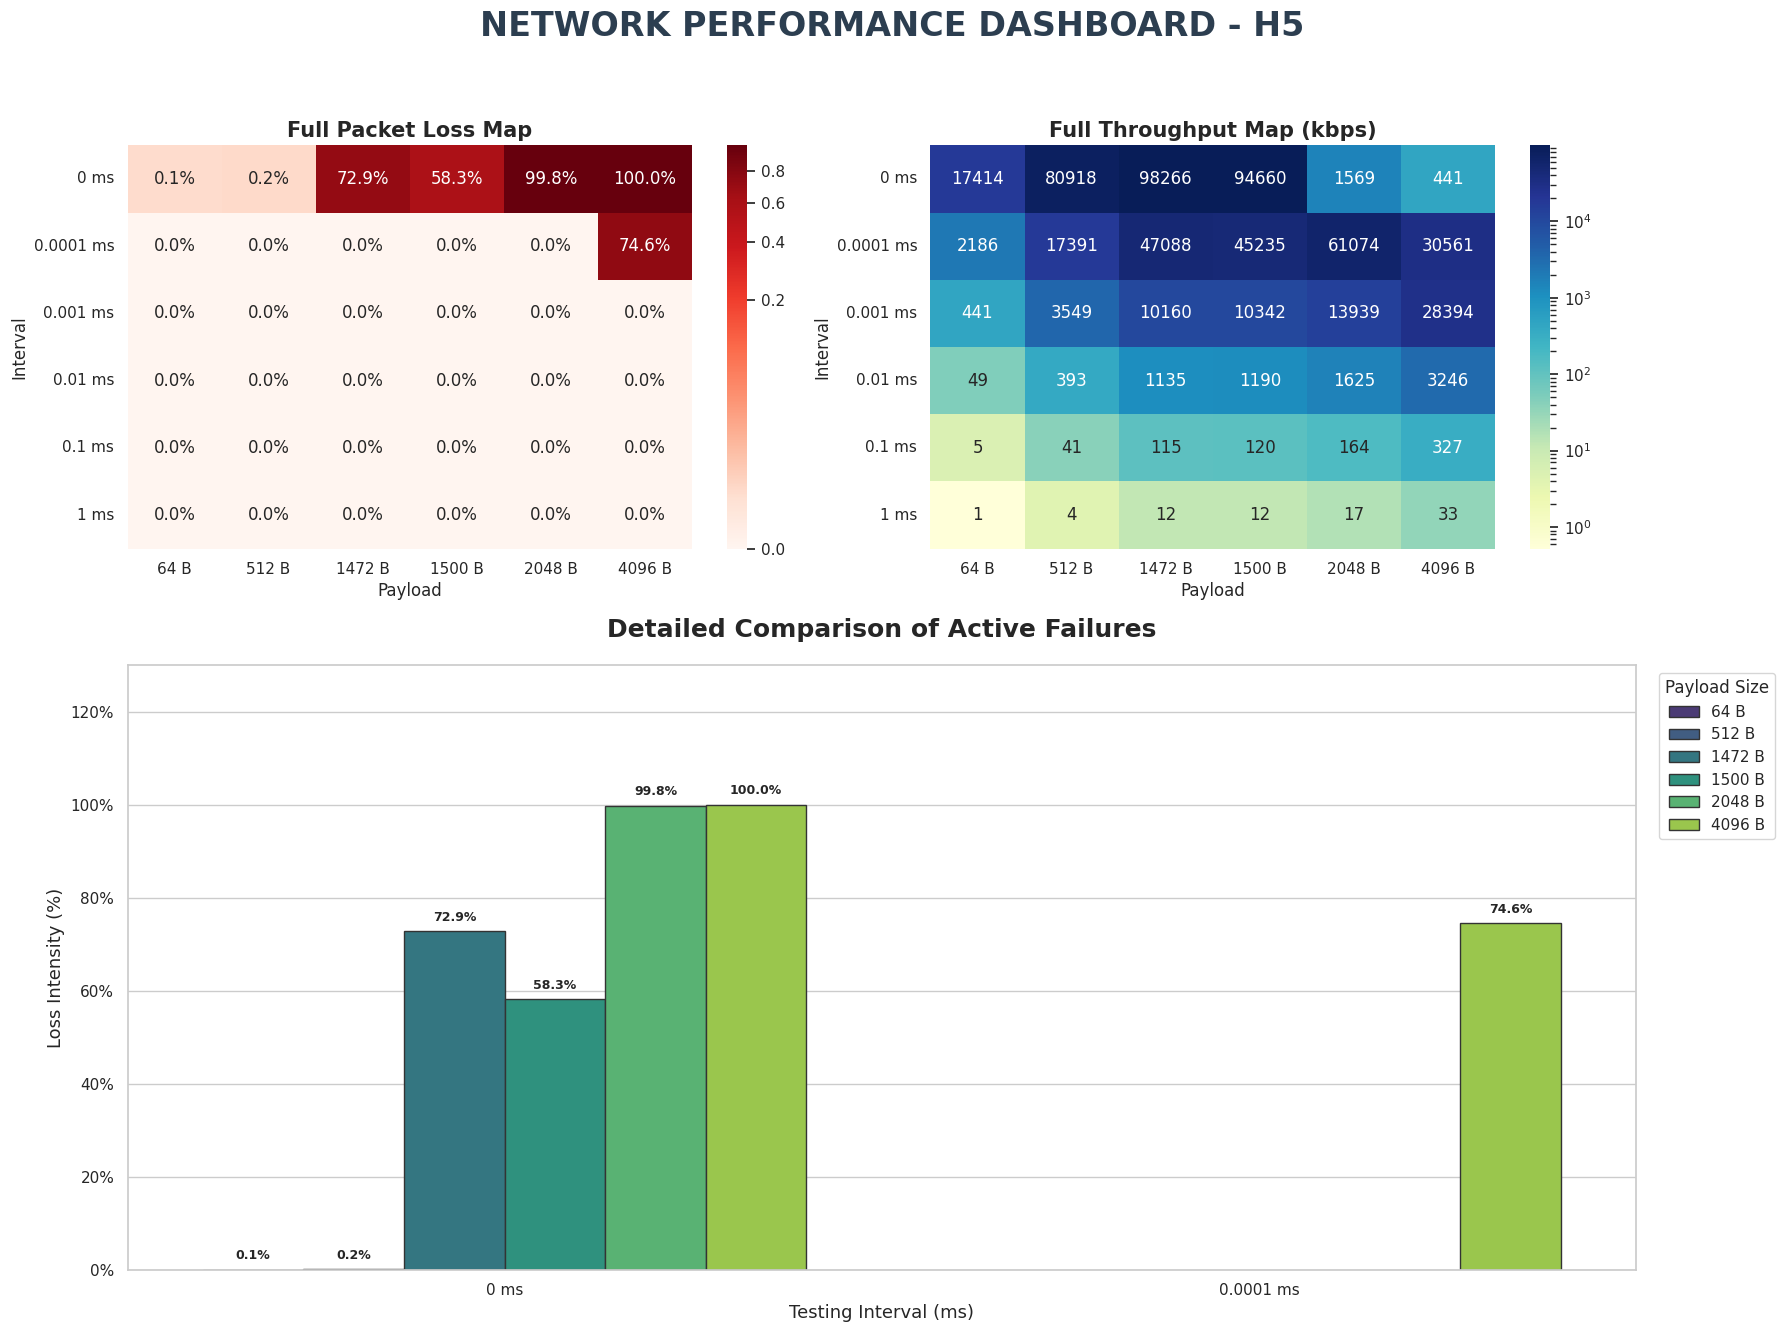

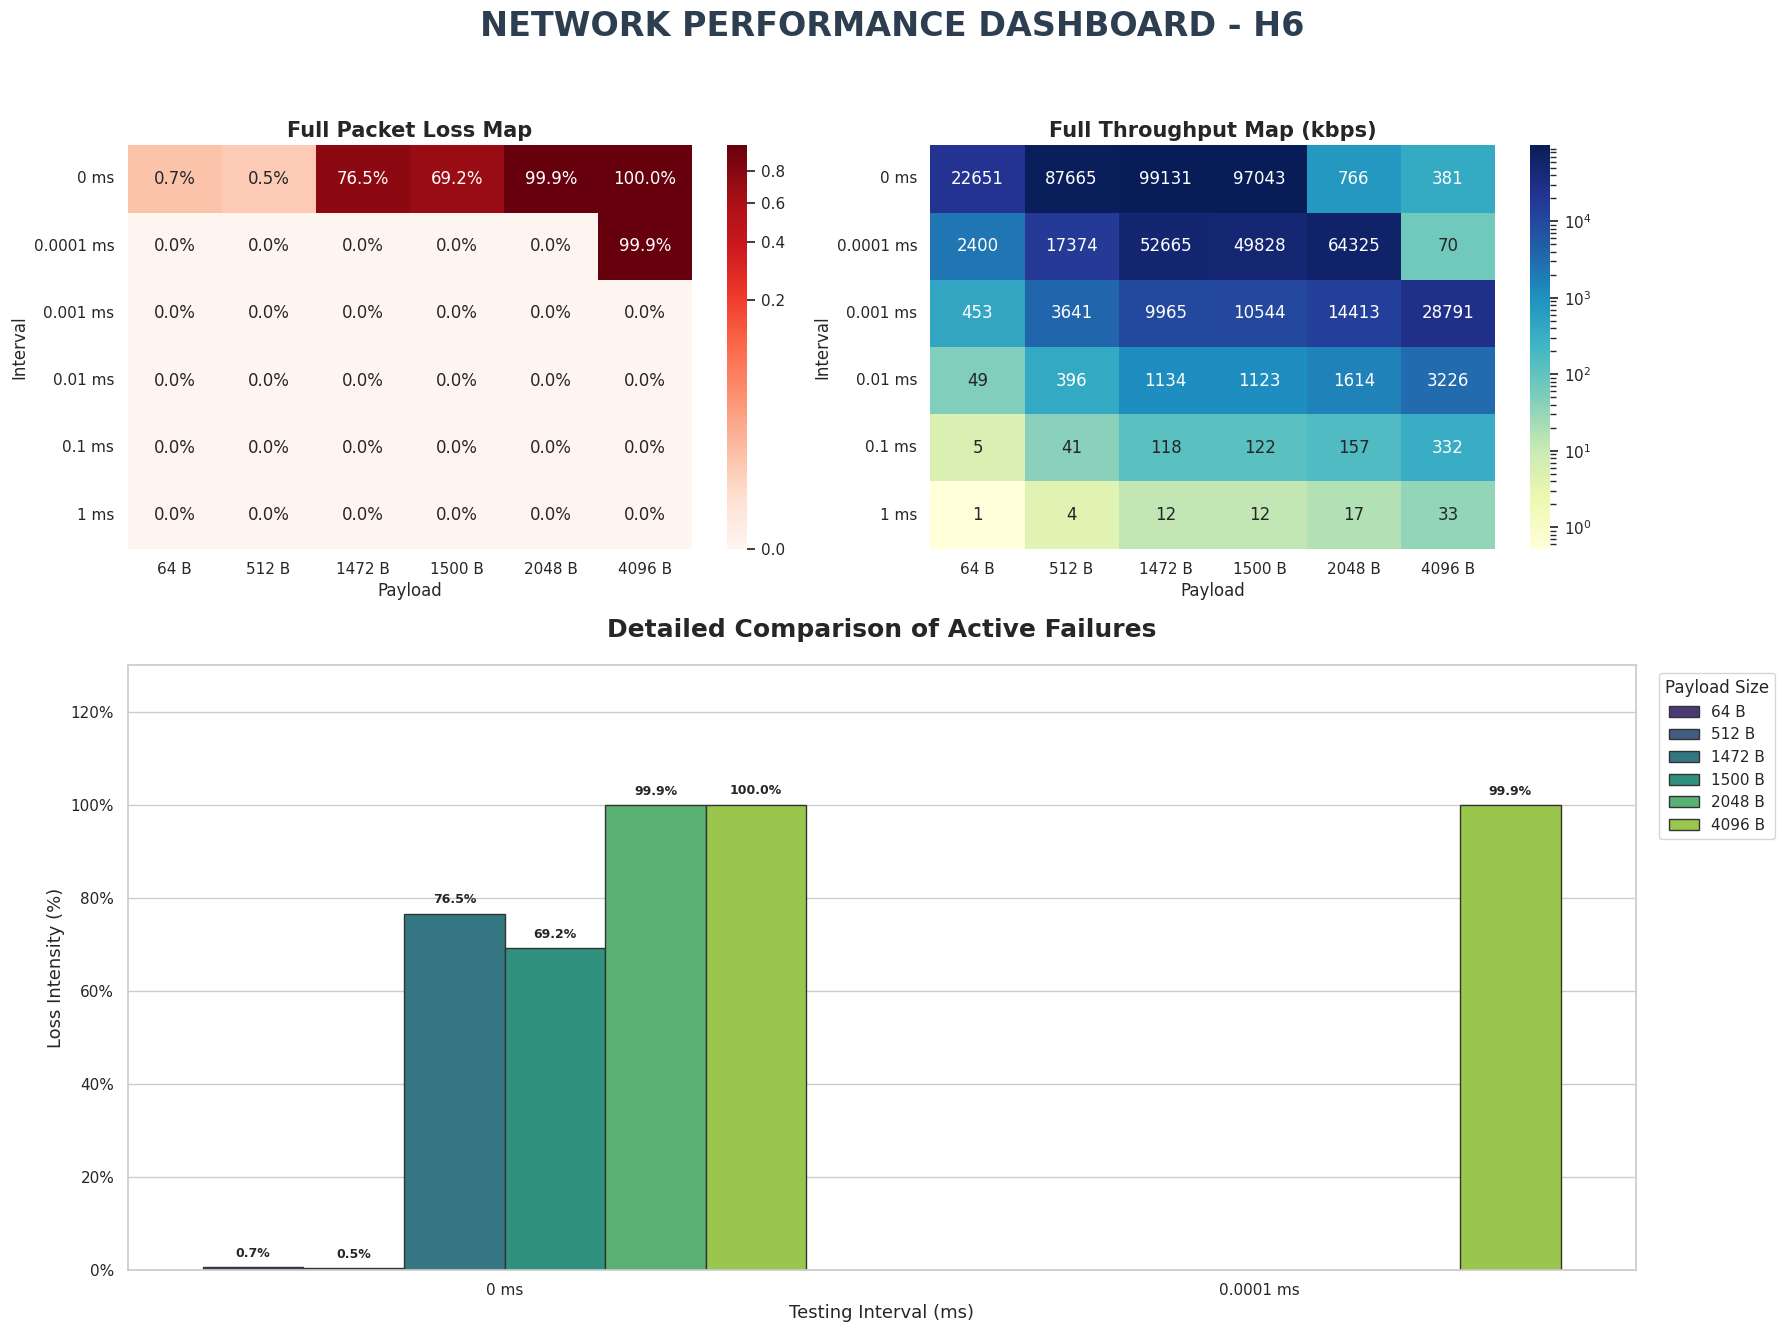

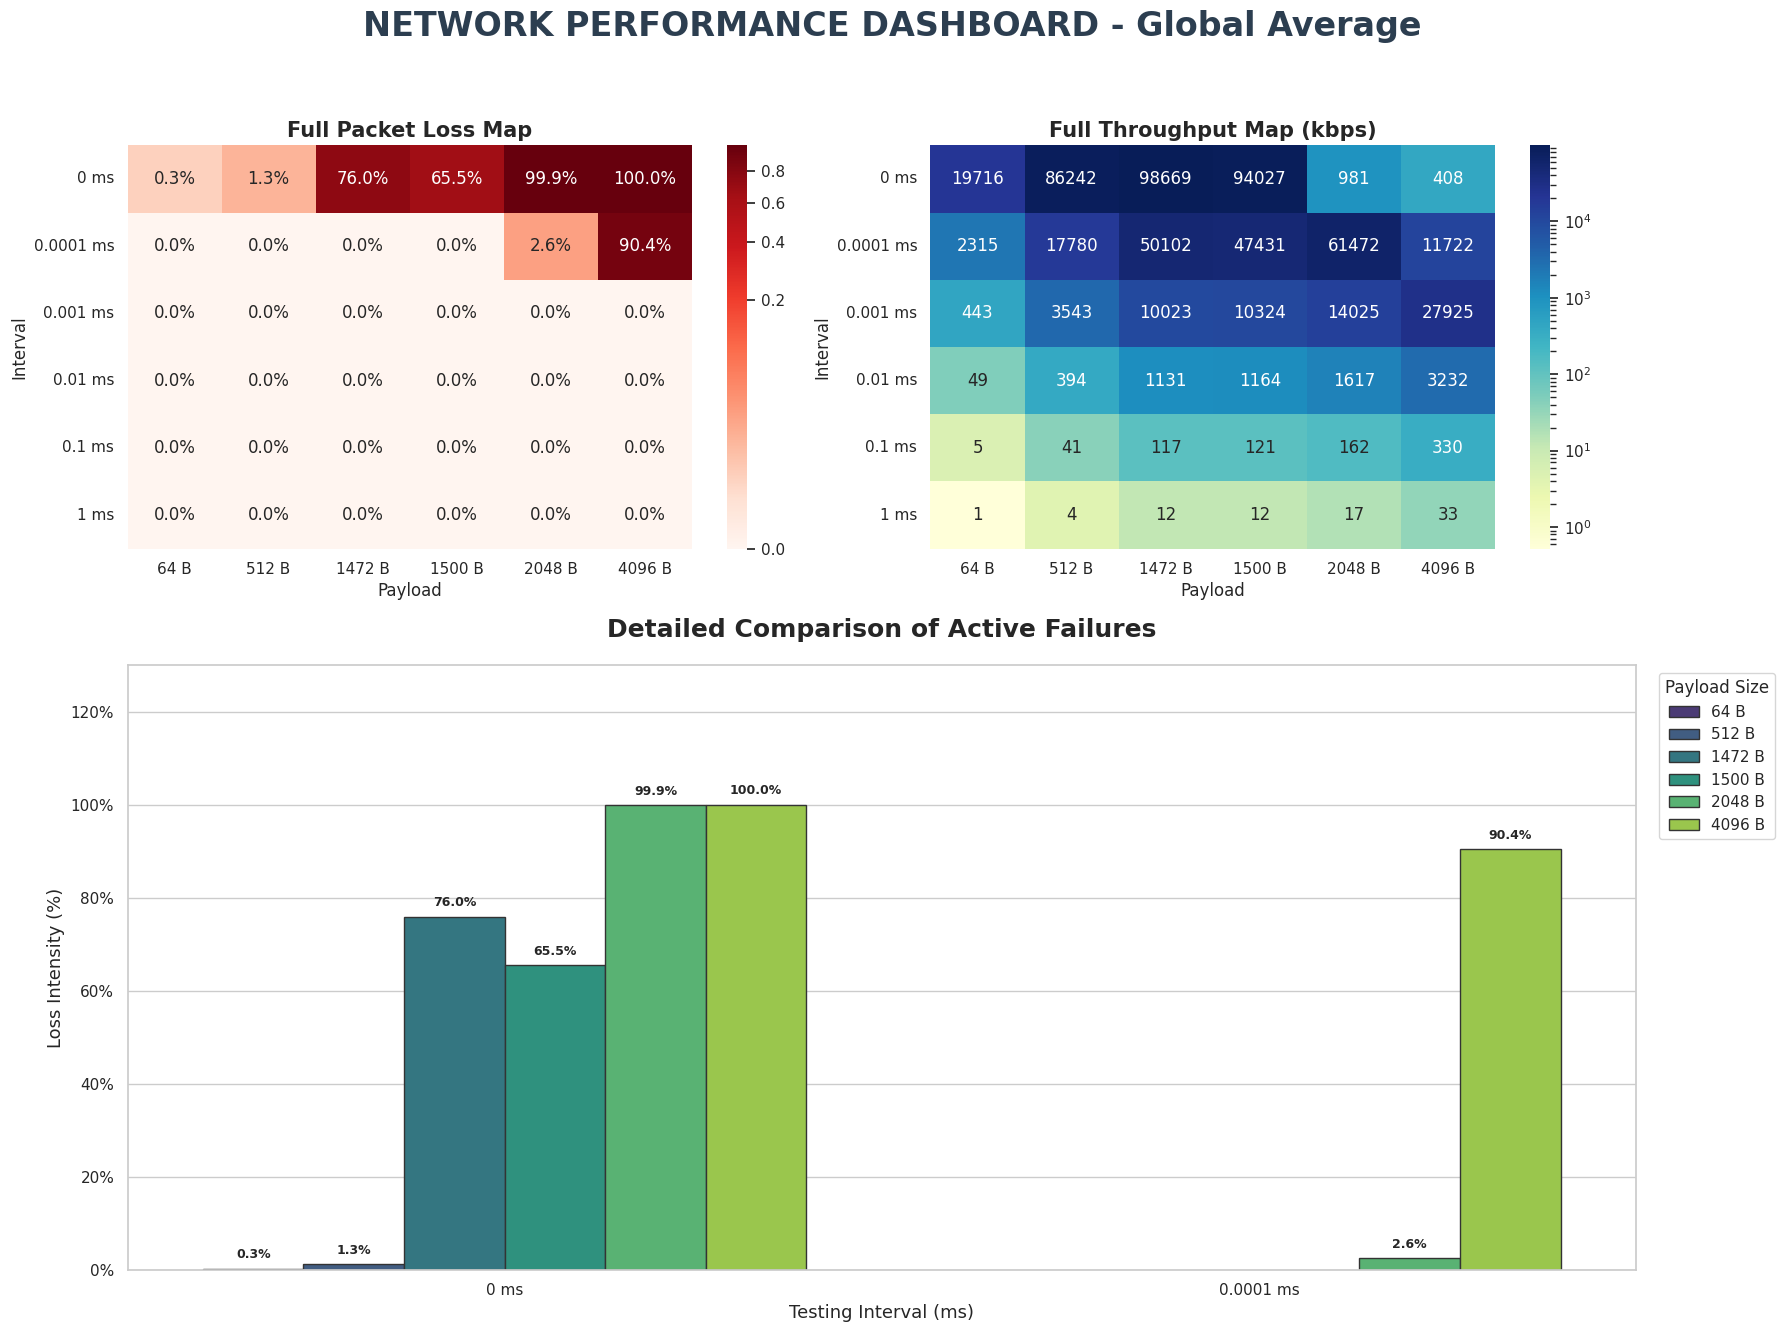

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.colors import LogNorm, PowerNorm

full_data = []
for host in hosts + ["Global Average"]:
    for interval in intervals:
        for length in lengths:
            # Calcolo metriche
            if host == "Global Average":
                loss = np.mean([differences[h][interval][length]["sent_loss_ratio"] for h in hosts])
                rate = np.mean([differences[h][interval][length]["data_rate"] for h in hosts])
            else:
                loss = differences[host][interval][length]["sent_loss_ratio"]
                rate = differences[host][interval][length]["data_rate"]
            
            full_data.append({
                "Host": host,
                "Interval": f"{interval} ms",
                "Payload": f"{length} B",
                "Loss": loss,
                "Rate": rate,
                "interval_int": interval
            })

df_all = pd.DataFrame(full_data)

# --- 2. GENERAZIONE DASHBOARD ---
for host in hosts + ["Global Average"]:
    # Dati completi per l'host corrente (per le Heatmaps)
    host_df = df_all[df_all['Host'] == host].copy()
    
    # Dati filtrati (solo perdite > 0) per il Bar Plot
    active_loss_df = host_df[host_df['Loss'] > 0].copy()

    # Creazione figura complessa
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])
    
    fig.suptitle(f'NETWORK PERFORMANCE DASHBOARD - {host}', 
                 fontsize=24, fontweight='bold', y=0.98, color='#2c3e50')

    ax_hm1 = fig.add_subplot(gs[0, 0])
    hm_loss = host_df.pivot_table(index='Interval', columns='Payload', values='Loss', sort=False)
    sns.heatmap(hm_loss, annot=True, fmt=".1%", cmap="Reds", norm=PowerNorm(0.3), cbar=True, ax=ax_hm1)
    ax_hm1.set_title("Full Packet Loss Map", fontsize=15, fontweight='bold')

    ax_hm2 = fig.add_subplot(gs[0, 1])
    hm_rate = host_df.pivot_table(index='Interval', columns='Payload', values='Rate', sort=False)
    vmin_rate = max(hm_rate.values[hm_rate.values > 0].min(), 0.1) if np.any(hm_rate.values > 0) else 0.1
    sns.heatmap(hm_rate, annot=True, fmt=".0f", cmap="YlGnBu", 
                norm=LogNorm(vmin=vmin_rate, vmax=hm_rate.values.max()), cbar=True, ax=ax_hm2)
    ax_hm2.set_title("Full Throughput Map (kbps)", fontsize=15, fontweight='bold')

    ax_bar = fig.add_subplot(gs[1, :])
    
    if not active_loss_df.empty:
        sns.barplot(data=active_loss_df, x="Interval", y="Loss", hue="Payload", 
                    palette="viridis", ax=ax_bar, edgecolor=".2")

        for p in ax_bar.patches:
            h = p.get_height()
            if h > 0:
                ax_bar.annotate(f'{h:.1%}', 
                                (p.get_x() + p.get_width() / 2., h), 
                                ha='center', va='center', xytext=(0, 10), 
                                textcoords='offset points', fontsize=9, fontweight='bold')
        
        ax_bar.set_title('Detailed Comparison of Active Failures', fontsize=18, fontweight='bold', pad=20)
    else:
        ax_bar.text(0.5, 0.5, "NO ACTIVE LOSS DETECTED\n(All tests performed perfectly)", 
                    ha='center', va='center', fontsize=16, color='green', fontweight='bold')
        ax_bar.set_title('Active Failure Analysis', fontsize=18, fontweight='bold')

    ax_bar.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax_bar.set_ylabel('Loss Intensity (%)', fontsize=13)
    ax_bar.set_xlabel('Testing Interval (ms)', fontsize=13)
    ax_bar.legend(title="Payload Size", bbox_to_anchor=(1.01, 1), loc='upper left')
    
    if not active_loss_df.empty:
        ax_bar.set_ylim(0, max(active_loss_df['Loss'].max() * 1.3, 0.1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()